# Проект "Отток клиентов"

## Описание данных

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Нужно построить модель с предельно большим значением F1-меры. Нужно довести метрику минимум до 0.59.
Проверить F1-меру на тестовой выборке.

Дополнительно измерить AUC-ROC, сравнивая её значение с F1-мерой.


  
**Цели и задачи:**  
- Проанализировать исторические данные о поведении клиентов банка, расторжении договоров. Спрогнозировать уход клиента из банка.
- Построить модель классификации, метрика качества f1 (минимальное значение 0.59)
- Измерить AUC-ROC, сравнить её значение с f1-мерой.

**План выполнения работы:**  
- 1. Подготовка данных  
    - 1.1 Загрузка данных  
    - 1.2 Подготовка признаков  
    - 1.3 Преобразование признака `Tenure`  
- 2. Исследование задачи  
    - 2.1 Решающее дерево  
    - 2.2 Случайный лес  
    - 2.3 Логистическая регрессия 
- 3. Борьба с дисбалансом  
    - 3.1 Взвешивание классов  
    - 3.2 Upsampling и Downsampling  
- 4. Тестирование модели  
- 5. Общий вывод  

**Описание данных:**  
Исторические данные о поведении клиентов и расторжении договоров с банком.  
Источник данных: https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling  
  
**Признаки**  
- `RowNumber` — индекс строки в данных
- `CustomerId` — уникальный идентификатор клиента
- `Surname` — фамилия
- `CreditScore` — кредитный рейтинг
- `Geography` — страна проживания
- `Gender` — пол
- `Age` — возраст
- `Tenure` — количество недвижимости у клиента
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов банка, используемых клиентом
- `HasCrCard` — наличие кредитной карты
- `IsActiveMember` — активность клиента
- `EstimatedSalary` — предполагаемая зарплата  
  
**Целевой признак**
- `Exited` — факт ухода клиента

# 1. Подготовка данных

## 1.1 Загрузка данных

Подключаем библиотеки:
- `pandas` - для работы с таблицами  
- `seaborn` - для визуализации данных
- `display` - для вывода табличных данных
- `sklearn` - инструменты машинного обучения (модели классификации, метрики для исследования качества моделей, разделение данных на тренировочные, валидационные, тестовые выборки)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, r2_score
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings(action='ignore')

Загрузим данные из файла `Churn.csv`, выведем первые 10 строк таблицы для первого взгляда на данные.  
Также с помощью метода info() изучим структуру таблицы: типы данных, количество строк, столбцов, пропущенных данных.

In [2]:
# читаем данные из .csv файла с помощью метода read_csv()
users = pd.read_csv('Churn.csv')
# выведем первые 10 строк таблицы с помощью метода head()
display(users.head(10))
# с помощью метода info() изучим структуры таблицы: типы данных, количество строк, столбцов, пропущенных данных.
users.info()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


## 1.2 Подготовка признаков

**1)** Признаки `RowNumber`, `CustomerId` и `Surname` не несут в себе информации, необходимой для дальнейшей классификации. Удалим их.

In [3]:
users = users.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

**2)** Посмотрим на распределения числовых признаков

In [4]:
def show_hists(data, data_label, num_bins, rug=False, log_scale=False):
    """
    input: data - данные для построения гистограммы
           data_label - описание данных
           num_bins - количество ячеек
    output: None
    description: Функция строит гистограмму и boxplot для выбранного параметра:
                - Плотность распределения (методом distplot() библиотеки seaborn)
                - Boxplot (метод boxplot() библиотеки seaborn)
    """
    sns.set()
    f, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes[0].set_title(data_label + ". Плотность распределения", fontsize=18)
    axes[0].set_ylabel('плотность', fontsize=15)
    sns.distplot(data, bins=num_bins, rug=rug, ax=axes[0])
    axes[1].set_title(data_label + ". Boxplot", fontsize=18)
    sns.boxplot(data=users, x=data_label, ax=axes[1])
    plt.show()

/Users/forcemajor01/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


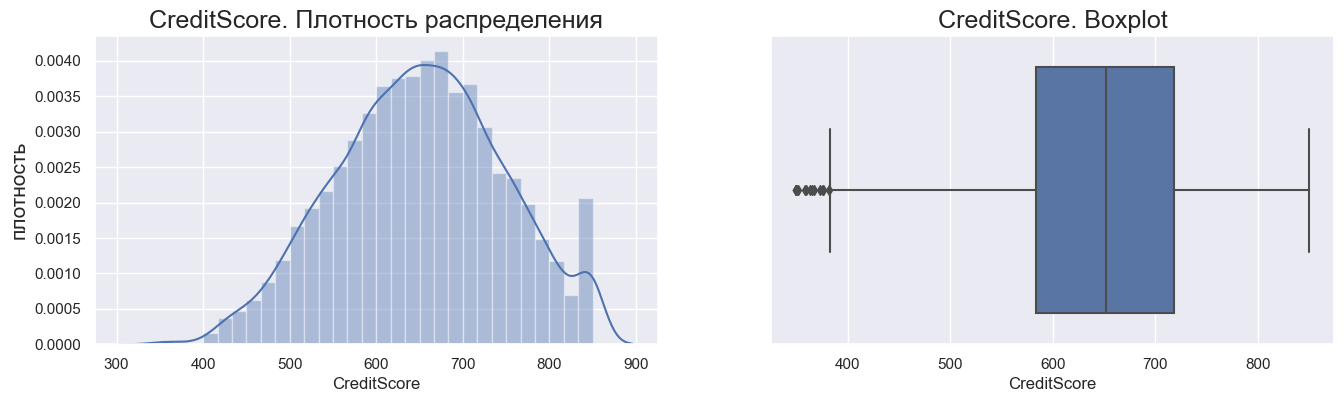

/Users/forcemajor01/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


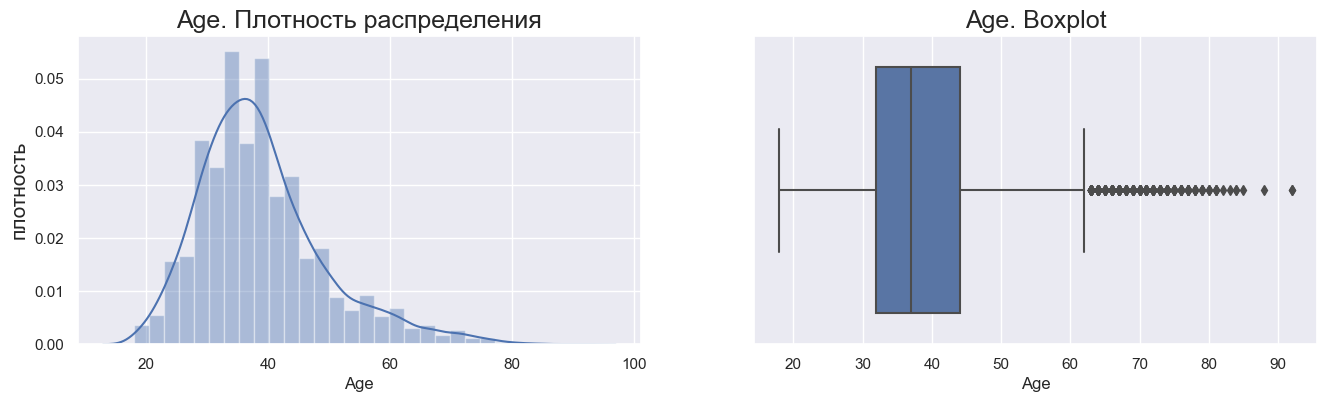

/Users/forcemajor01/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


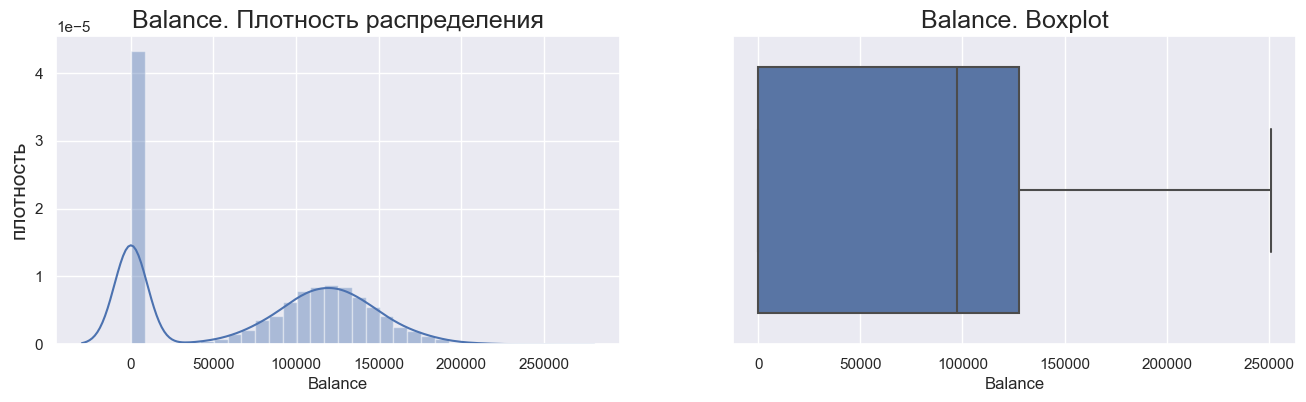

/Users/forcemajor01/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


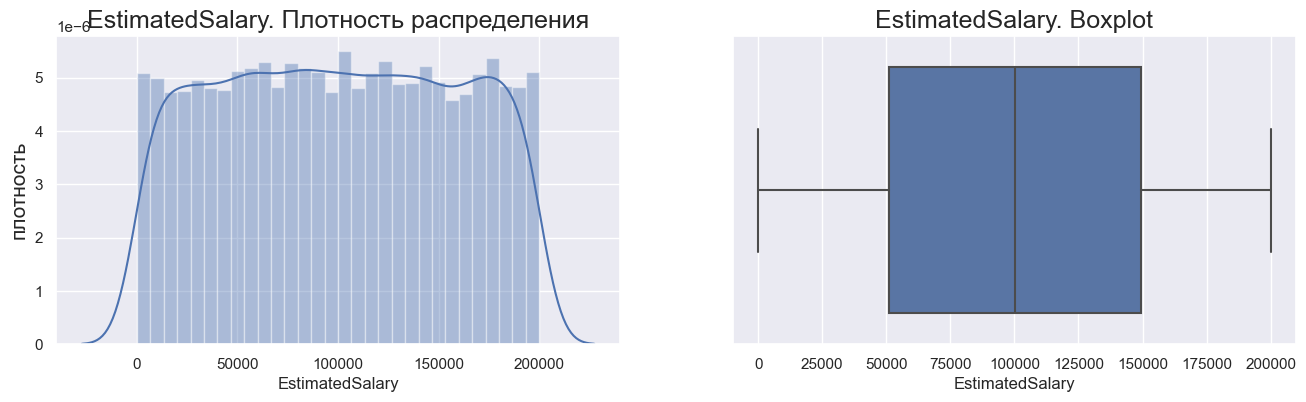

In [5]:
numerics = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
for column in numerics:
    show_hists(users[column], column, num_bins=30)

- В признаках `CreditScore`, `Age` есть выбросы. Найдём их долю от общего количества данных.

In [6]:
# квантили считаем методом quantile()
# граница выбросов считается по формуле  [ q.75 + (q.75 - q.25)*1.5 ]
max_age = (users['Age'].quantile(0.75) - users['Age'].quantile(0.25))*1.5 + users['Age'].quantile(0.75)
rate = round(len(users.loc[users['Age'] > max_age]) / len(users) * 100, 2)
print('Доля выбросов в параметре {}: {} %'.format('Age', rate))

Доля выбросов в параметре Age: 3.59 %


In [7]:
# граница выбросов считается по формуле  [ q.25 - (q.75 - q.25)*1.5 ]
min_score = users['CreditScore'].quantile(0.25) - \
            (users['CreditScore'].quantile(0.75) - users['CreditScore'].quantile(0.25))*1.5
rate = round(len(users.loc[users['CreditScore'] < min_score]) / len(users) * 100, 2)
print('Доля выбросов в параметре {}: {} %'.format('CreditScore', rate))

Доля выбросов в параметре CreditScore: 0.15 %


Общая доля выбросов небольшая (меньше 4%). Не будем пока их удалять.

- К числовым признакам `CreditScore`, `Age`, `Balance`, `EstimatedSalary` применим масштабирование с помощью `StandardScaler` библиотеки `sklearn`

In [8]:
scaler = StandardScaler()
users[numerics] = scaler.fit_transform(users[numerics])

**3)** Посмотрим на распределения категориальных признаков.

In [9]:
def show_hists(data, data_label1, data_label2=''):
    """
    input: data - данные для построения гистограммы
           data_label1,2 - названия признаков
    output: None
    description: Функция строит countplot для двух признаков
    """
    sns.set()
    f, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes[0].set_title(data_label1 + ". CountPlot", fontsize=18)
    sns.countplot(data=users, x=data_label1, ax=axes[0])
    if data_label2 != '':
        axes[1].set_title(data_label2 + ". CountPlot", fontsize=18)
        sns.countplot(data=users, x=data_label2, ax=axes[1])
    plt.show()

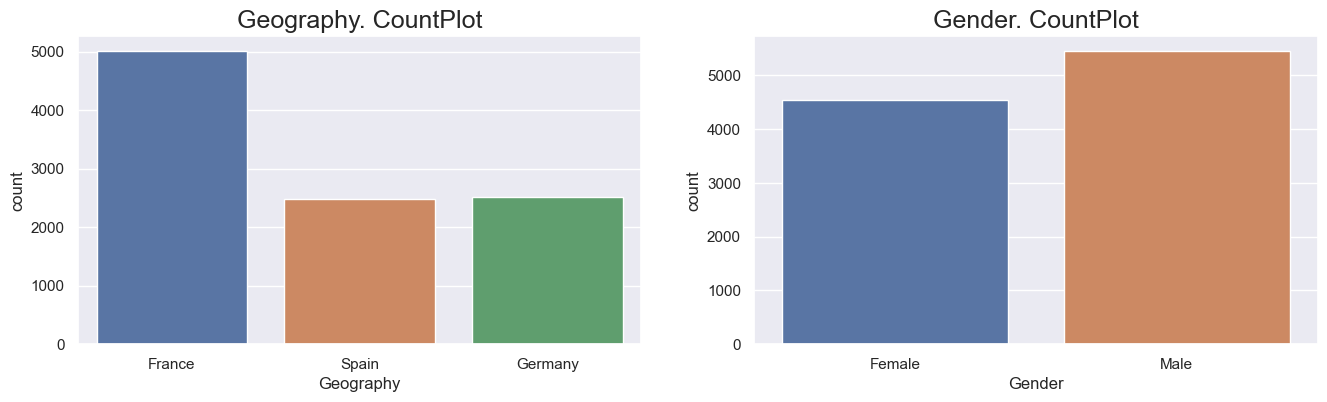

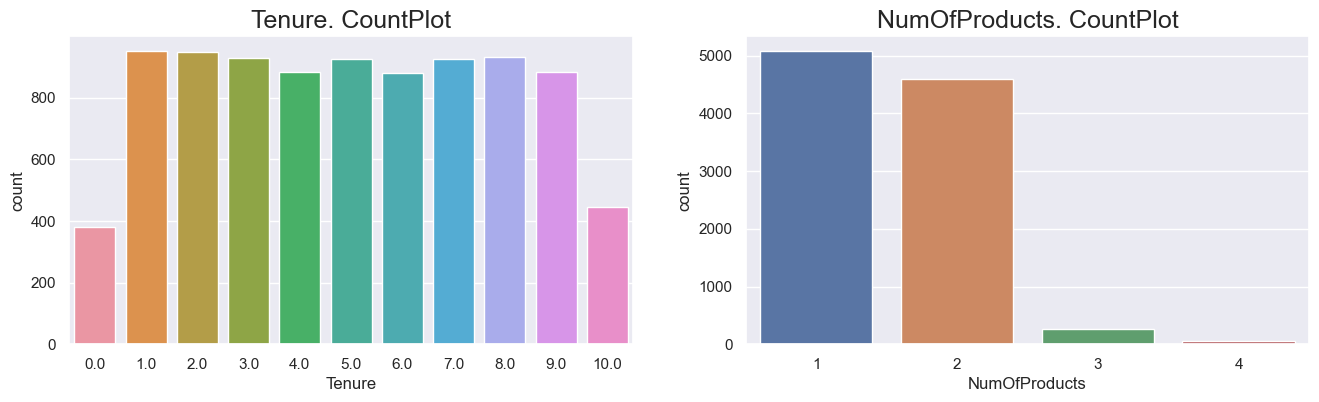

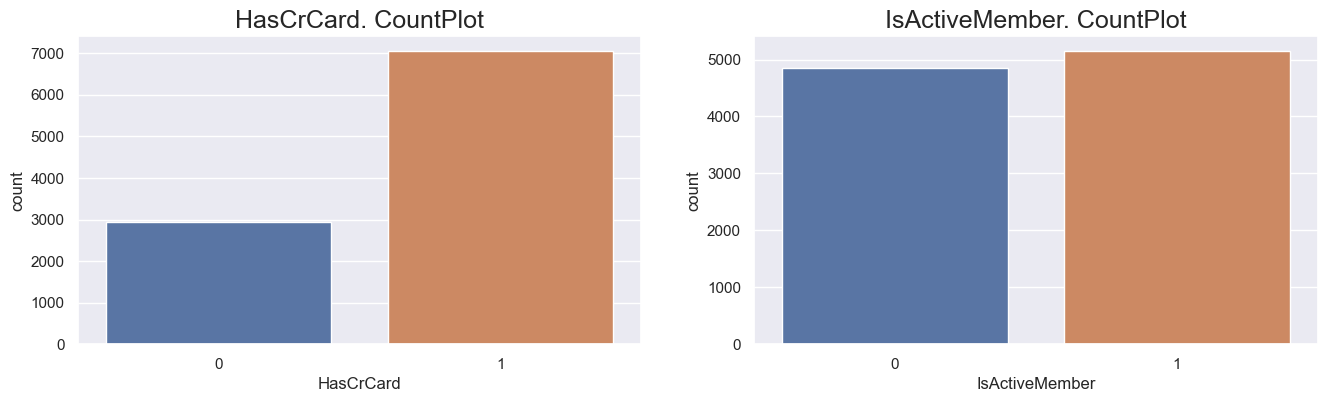

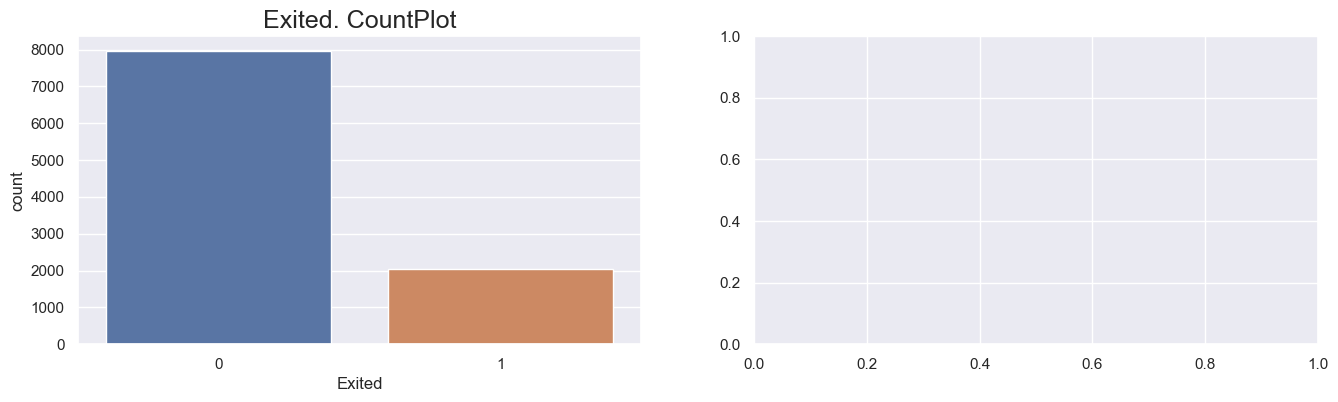

In [10]:
categoricals = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited', '']
for i in range(len(categoricals)//2):
    show_hists(users, categoricals[2*i], categoricals[2*i+1])

- Целевой признак `Exited` распределён примерно 4:1.
- Количество категорий в признаках `Geography`, `Gender` небольшое. Преобразуем их методом One-Hot Encoding.

In [11]:
# для преобразования воспользуемся методом pd.get_dummies
# параметр drop_first=True для удаления избыточного столбца данных
users = pd.get_dummies(users, drop_first=True)

**4)** Преобразуем типы данных признаков `NumOfProducts`, `HasCrCard`, `IsActiveMember`, `Exited` в `int8` для экономии места.

In [12]:
for column in ['NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']:
    users[column] = users[column].astype('int8')

## 1.3 Преобразование признака `Tenure`

- В столбце `Tenure` есть пропущенные данные (около 10% пропусков). Данные могли отсутствовать изначально или быть утеряны из-за сбоев в системе при выгрузке базы.
- Попробуем построить модель, предсказывающую данный параметр на основе имеющихся данных.

In [13]:
users.loc[users['Tenure'].isna(), 'Tenure'] = users['Tenure'].median()
users['Tenure'] = users['Tenure'].astype('object')
users = pd.get_dummies(users, drop_first=True)

/Users/forcemajor01/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


- Выведем информацию о получившейся таблице.

In [14]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  float64
 1   Age                10000 non-null  float64
 2   Balance            10000 non-null  float64
 3   NumOfProducts      10000 non-null  int8   
 4   HasCrCard          10000 non-null  int8   
 5   IsActiveMember     10000 non-null  int8   
 6   EstimatedSalary    10000 non-null  float64
 7   Exited             10000 non-null  int8   
 8   Geography_Germany  10000 non-null  uint8  
 9   Geography_Spain    10000 non-null  uint8  
 10  Gender_Male        10000 non-null  uint8  
 11  Tenure_1.0         10000 non-null  uint8  
 12  Tenure_2.0         10000 non-null  uint8  
 13  Tenure_3.0         10000 non-null  uint8  
 14  Tenure_4.0         10000 non-null  uint8  
 15  Tenure_5.0         10000 non-null  uint8  
 16  Tenure_6.0         1000

In [15]:
display(users.head(10))

,CreditScore,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,...,Tenure_1.0,Tenure_2.0,Tenure_3.0,Tenure_4.0,Tenure_5.0,Tenure_6.0,Tenure_7.0,Tenure_8.0,Tenure_9.0,Tenure_10.0
0,-0.326221,0.293517,-1.225848,1,1,1,0.021886,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,-0.440036,0.198164,0.117350,1,0,1,0.216534,0,0,1,...,1,0,0,0,0,0,0,0,0,0
2,-1.536794,0.293517,1.333053,3,1,0,0.240687,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.501521,0.007457,-1.225848,2,0,0,-0.108918,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,2.063884,0.388871,0.785728,1,1,1,-0.365276,0,0,1,...,0,1,0,0,0,0,0,0,0,0
5,-0.057205,0.484225,0.597329,2,1,0,0.863650,1,0,1,...,0,0,0,0,0,0,0,1,0,0
6,1.774174,1.056346,-1.225848,2,1,1,-1.565487,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7,-2.840488,-0.946079,0.618019,4,1,0,0.334854,1,1,0,...,0,0,0,1,0,0,0,0,0,0
8,-1.547141,0.484225,1.050820,2,0,1,-0.437329,0,0,0,...,0,0,0,1,0,0,0,0,0,0
9,0.346319,-1.136786,0.931463,1,1,1,-0.493230,0,0,0,...,0,1,0,0,0,0,0,0,0,0


### Выводы

- Данные успешно загружены и проверены на соответствие описанию. Дубликатов нет. Типы данных преобразованы в соответствии с хранимой информацией
- Признаки `RowNumber`, `CustomerId` и `Surname` удалены, так как целевой признак от них никак не зависит.
- Были рассмотрены распределения признаков. В `CreditScore`, `Age` найдено около 4% выбросов. Пока оставлены как есть.
- Числовые признаки приведены к стандартному виду (среднее = 0, стандартное отклонение = 1)
- Категориальные признаки преобразованы методом One-Hot Encoder.
- Целевой признак распределён в сооотношении **4:1**
- В признаке `Tenure` обнаружено около 10% пропусков. Попытка построить классификационную модель для заполнения пропусков не принесла существенных результатов (качество модели 12%, при случайном заполнении 9%). Данный признак преобразован прямым кодированием One-Hot Encoder.

# 2. Исследование задачи

- Для начала разделим данные на признаки и целевой признак

In [16]:
features = users.drop('Exited', axis=1)
target = users['Exited']

- Разделим данные на обучающую, валидационную и тестовую выборки в пропорции 3:1:1 соответственно (60% на обучающию и по 20% данных на валидационную и тестовую выборки).

In [17]:
# разделение проведём с помощью функции train_test_split библиотеки sklearn
X, X_test, y, y_test = train_test_split(features, target, test_size=0.2, random_state=123)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=123)

In [18]:
# выведем размеры получившихся выборок
print('Размеры наборов данных:')
print('X_train: ', X_train.shape)
print('X_valid: ', X_valid.shape)
print('X_test:  ', X_test.shape)

Размеры наборов данных:
X_train:  (6000, 20)
X_valid:  (2000, 20)
X_test:   (2000, 20)


- Попробуем обучить различные классификационные модели без учёта дисбаланса классов.

## 2.1 Решающее дерево

- Инициируем модель решающего дерева DecisionTreeClassifier
- Выделим гиперпараметры для настройки модели:
    - `max_depth` - максимальная глубина древа
    - `min_samples_split` - минимальное количество объектов в узле
    - `min_samples_leaf` - минимальное количество объектов в листе
    - `criterion` ("gini" или "entropy") - функция измерения качества разделения
- Критерием проверки качества модели будет `f1` и `roc_auc`.

In [19]:
def decision_tree(X_train, X_valid, y_train, y_valid, cw=None):
    """
    input: X_train, X_valid, y_train, y_valid - обучающие и валидационные выборки признаков и целевого признака
            cw - параметр class_weight для модели решающего дерева
    output: None
    description: функция обучает модель решающего дерева DecisionTreeClassifier с различными сочетаниями гиперпараметров;
                 метрики качества модели: f1 и roc_auc;
                 функция выводит наилучшие значения метрик и значения гиперпараметров наилучшей модели.
    """
    # в параметрах best_params_f1 и best_f1 будем хранить наилучшие параметры для модели и наивысшую f1 метрику соответственно
    best_params_f1 = []
    best_f1 = 0
    # аналогично для roc_auc метрики.
    best_params_roc_auc = []
    best_roc_auc = 0.5
    # проходим в циклах по всем выбранным гиперпараметрам
    for max_depth in range(2,10):
        for min_samples_split in range(2,6):
            for min_samples_leaf in range(1,10):
                for criterion in ['gini', 'entropy']:
                    # инициация модели с текущими гиперпараметрами
                    model_dt_clf = DecisionTreeClassifier(random_state=123,
                                                          max_depth=max_depth,
                                                          min_samples_split=min_samples_split,
                                                          min_samples_leaf=min_samples_leaf,
                                                          criterion=criterion,
                                                          class_weight=cw)
                    # обучение модели на тренировочной выборке
                    model_dt_clf.fit(X_train, y_train)
                    # поиск предсказаний модели на валидационной выбоке
                    predictions = model_dt_clf.predict(X_valid)
                    # вычисление f1 модели методом f1_score
                    f1 = f1_score(y_valid, predictions)
                    # если текущее значение метрики f1 выше предыдущего лучшего значения, 
                    # сохраняем параметры модели и текущую метрику f1
                    if f1 > best_f1:
                        best_params_f1 = [max_depth, min_samples_split, min_samples_leaf, criterion]
                        best_f1 = f1
                    # аналогично для метрики roc_auc
                    roc_auc = roc_auc_score(y_valid, predictions)
                    if roc_auc > best_roc_auc:
                        best_params_roc_auc = [max_depth, min_samples_split, min_samples_leaf, criterion]
                        best_roc_auc = roc_auc
    
    # вывод наилучшей метрики f1 и параметров модели.
    print('''Наилучшая метрика f1: {}
    Парамтеры модели:
       max_depth = {}
       min_samples_split = {}
       min_samples_leaf = {}
       criterion = {} \n'''.format(round(best_f1, 3),
                                 best_params_f1[0],
                                 best_params_f1[1],
                                 best_params_f1[2],
                                 best_params_f1[3]
                                ))
    
    # вывод наилучшей метрики roc_auc и параметров модели.
    print('''Наилучшая метрика roc_auc: {}
    Парамтеры модели:
       max_depth = {}
       min_samples_split = {}
       min_samples_leaf = {}
       criterion = {} '''.format(round(best_roc_auc, 3),
                                 best_params_roc_auc[0],
                                 best_params_roc_auc[1],
                                 best_params_roc_auc[2],
                                 best_params_roc_auc[3]
                                ))

In [20]:
decision_tree(X_train, X_valid, y_train, y_valid)

Наилучшая метрика f1: 0.569
    Парамтеры модели:
       max_depth = 5
       min_samples_split = 2
       min_samples_leaf = 4
       criterion = gini 

Наилучшая метрика roc_auc: 0.711
    Парамтеры модели:
       max_depth = 5
       min_samples_split = 2
       min_samples_leaf = 4
       criterion = gini 


- Наилучшая метрика f1 для решающего дерева 0.57 (не достаточно по техническому заданию).
- Наилучший результат по метрикам f1 и roc_auc достигается при одинаковой настройке гиперпараметров.
- Попробуем улучшить результат на других моделях

## 2.2 Случайный лес

- Инициируем модель случайного леса RandomForestClassifier
- Выделим гиперпараметры для настройки модели:
    - `n_estimators` - количество деревьев
    - `max_depth` - максимальная глубина древа
    - `min_samples_split` - минимальное количество объектов в узле
    - `min_samples_leaf` - минимальное количество объектов в листе
- Критерием проверки качества модели будет `f1` и `roc_auc`.

In [21]:
def random_forest(X_train, X_valid, y_train, y_valid, cw=None):
    """
    input: X_train, X_valid, y_train, y_valid - обучающие и валидационные выборки признаков и целевого признака
            cw - параметр class_weight для модели случайного леса
    output: None
    description: функция обучает модель решающего дерева RandomForestClassifier с различными сочетаниями гиперпараметров;
                 метрики качества модели: f1 и roc_auc;
                 функция выводит наилучшие значения метрик и значения гиперпараметров наилучшей модели.
    """
    # в параметрах best_params_f1 и best_f1 будем хранить наилучшие параметры для модели и наивысшую f1 метрику соответственно
    best_params_f1 = []
    best_f1 = 0
    # аналогично для roc_auc метрики.
    best_params_roc_auc = []
    best_roc_auc = 0.5
    # проходим в циклах по всем выбранным гиперпараметрам
    for n_estimators in range(30,40):
        for max_depth in range(10,17,2):
            for min_samples_split in range(2,5):
                for min_samples_leaf in range(1,4):
                    # инициация модели с текущими гиперпараметрами
                    model_rf_clf = RandomForestClassifier(random_state=123,
                                                          n_estimators=n_estimators,
                                                          max_depth=max_depth,
                                                          min_samples_split=min_samples_split,
                                                          min_samples_leaf=min_samples_leaf)
                    # обучение модели на тренировочной выборке
                    model_rf_clf.fit(X_train, y_train)
                    # поиск предсказаний модели на валидационной выбоке
                    predictions = model_rf_clf.predict(X_valid)

                    # вычисление f1 модели методом f1_score
                    f1 = f1_score(y_valid, predictions)
                    # если текущее значение метрики f1 выше предыдущего лучшего значения, 
                    # сохраняем параметры модели и текущую метрику f1
                    if f1 > best_f1:
                        best_params_f1 = [n_estimators, max_depth, min_samples_split, min_samples_leaf]
                        best_f1 = f1
                    # аналогично для метрики roc_auc
                    roc_auc = roc_auc_score(y_valid, predictions)
                    if roc_auc > best_roc_auc:
                        best_params_roc_auc = [n_estimators, max_depth, min_samples_split, min_samples_leaf]
                        best_roc_auc = roc_auc

    # вывод наилучшей метрики f1 и параметров модели.
    print('''Наилучшая метрика f1: {}
    Парамтеры модели:
       n_estimators = {}
       max_depth = {}
       min_samples_split = {}
       min_samples_leaf = {} \n'''.format(round(best_f1, 3),
                                 best_params_f1[0],
                                 best_params_f1[1],
                                 best_params_f1[2],
                                 best_params_f1[3]
                                ))

    # вывод наилучшей метрики roc_auc и параметров модели.
    print('''Наилучшая метрика roc_auc: {}
    Парамтеры модели:
       n_estimators = {}
       max_depth = {}
       min_samples_split = {}
       min_samples_leaf = {} '''.format(round(best_roc_auc, 3),
                                 best_params_roc_auc[0],
                                 best_params_roc_auc[1],
                                 best_params_roc_auc[2],
                                 best_params_roc_auc[3]
                                ))

In [22]:
random_forest(X_train, X_valid, y_train, y_valid)

Наилучшая метрика f1: 0.568
    Парамтеры модели:
       n_estimators = 38
       max_depth = 16
       min_samples_split = 2
       min_samples_leaf = 1 

Наилучшая метрика roc_auc: 0.704
    Парамтеры модели:
       n_estimators = 38
       max_depth = 16
       min_samples_split = 2
       min_samples_leaf = 1 


- Наилучшая метрика f1 для случайного леса 0.58 (не достаточно по техническому заданию).
- Наилучший результат по метрикам f1 и roc_auc достигается при одинаковой настройке гиперпараметров.
- Попробуем улучшить результат на других моделях.

## 2.3 Логистическая регрессия

- Инициируем модель логистической регрессии LogisticRegression
- Выделим гиперпараметры для настройки модели:
    - `С` - инверсия силы регуляризации
- Критерием проверки качества модели будет `f1` и `roc_auc`.

In [23]:
# в параметрах best_params_f1 и best_f1 будем хранить наилучшие параметры для модели и наивысшую f1 метрику соответственно
best_params_f1 = []
best_f1 = 0
# аналогично для roc_auc метрики.
best_params_roc_auc = []
best_roc_auc = 0.5

#cs = np.linspace(0.01, 100, 1000, endpoint=True)
cs = range(1, 100)
# проходим в циклах по всем выбранным гиперпараметрам
for C in cs:
    # инициация модели с текущими гиперпараметрами
    model_lr_clf = LogisticRegression(random_state=123,
                                      C=C,
                                      max_iter=1000)
    # обучение модели на тренировочной выборке
    model_lr_clf.fit(X_train, y_train)
    # поиск предсказаний модели на валидационной выбоке
    predictions = model_lr_clf.predict(X_valid)

    # вычисление f1 модели методом f1_score
    f1 = f1_score(y_valid, predictions)
    # если текущее значение метрики f1 выше предыдущего лучшего значения, 
    # сохраняем параметры модели и текущую метрику f1
    if f1 > best_f1:
        best_params_f1 = [C]
        best_f1 = f1
    # аналогично для метрики roc_auc
    roc_auc = roc_auc_score(y_valid, predictions)
    if roc_auc > best_roc_auc:
        best_params_roc_auc = [C]
        best_roc_auc = roc_auc

In [24]:
# вывод наилучшей метрики f1 и параметров модели.
print('''Наилучшая метрика f1: {}
Парамтеры модели:
   C = {} '''.format(round(best_f1, 3),
                             best_params_f1[0]
                            ))

Наилучшая метрика f1: 0.27
Парамтеры модели:
   C = 1 


In [25]:
# вывод наилучшей метрики roc_auc и параметров модели.
print('''Наилучшая метрика roc_auc: {}
Парамтеры модели:
   C = {} '''.format(round(best_roc_auc, 3),
                             best_params_roc_auc[0]
                            ))

Наилучшая метрика roc_auc: 0.571
Парамтеры модели:
   C = 1 


- Наилучшая метрика f1 для логистической регрессии 0.27 (хуже, чем на остальных моделях).
- Наилучший результат по метрикам f1 и roc_auc достигается при одинаковой настройке гиперпараметров.
- Попробуем улучшить результат, разобравшись с дисбалансом классов.

### Выводы

- Исходные данные разделены на обучающую, валидационную и тестовую выборки в соотношении 3:1:1 соответственно
- Обучены модели "Решающее Дерево", "Случайный лес", "Логистическая Регрессия" без учёта дисбаланса классов. Максимальное значение метрики **f1 = 0.58** получено при обучении модели случайного леса. Качество модели не удовлетворяет условию технического задания.
- Качество моделей также оценено по метрике roc_auc. Максимальное значение метрики **roc_auc = 0.71** достигнуто при обучении модели случайного леса. 
- Метрики f1 и roc_auc достигли максимальных значений при одинаковых настройках гиперпараметров (но такой результат получается не всегда).

# 3. Борьба с дисбалансом

- Соотношение значений целевого признака 4:1 (для классов 0 и 1 соответственно)
- Для борьбы с дисбалансом классов попробуем:
    - взвешивание классов (class_weight='balanced')
    - увеличение выборки положительного класса (копирование объектов)
    - уменьшение выборки отрицательного класса (sampling)
    - перемешивание объектов методом shuffle

## 3.1 Взвешивание классов

In [26]:
decision_tree(X_train, X_valid, y_train, y_valid, cw='balanced')

Наилучшая метрика f1: 0.564
    Парамтеры модели:
       max_depth = 8
       min_samples_split = 2
       min_samples_leaf = 9
       criterion = gini 

Наилучшая метрика roc_auc: 0.751
    Парамтеры модели:
       max_depth = 6
       min_samples_split = 2
       min_samples_leaf = 8
       criterion = gini 


- Взвешивание классов почти не дало прироста в метрике f1 на решающем дереве. 
- Отметим, что в данном случае наилучшие значения метрик f1 и roc_auc достигаются при различных настройках гиперпараметров.
- Применим upsampling и downsampling. Проверим результаты на модели случайного леса (она дала наилучший результат при начальном исследовании)

## 3.2 Upsampling и downsampling

- Напишем функции для увеличения и уменьшения выборок.

In [27]:
def upsample(features, target, repeat):
    """
    input:        features - признаки 
                  target - целево признак
                  repeat (int) - множитель для повторения признаков
    output:       features_upsampled - увеличенная выборка признаков
                  target_upsampled - увеличенная выборка целевого признака
    description:  функция разделяет признаки по классам целевого признака (0, 1),
                  повторяет признаки целевого положительного класса repeat раз,
                  объединяет объекты с разными целевыми признаками методом concat,
                  перемешивает объекты методом shuffle
    """
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

In [28]:
def downsample(features, target, fraction):
    """
    input:        features - признаки 
                  target - целево признак
                  fraction (float) - доля объектов для сэмплирования
    output:       features_downsampled - уменьшенная выборка признаков
                  target_downsampled - уменьшенная выборка целевого признака
    description:  функция разделяет признаки по классам целевого признака (0, 1), 
                  сэмплирует признаки целевого класса 0 (с коэффициентом fraction),
                  объединяет объекты с разными целевыми признаками методом concat,
                  перемешивает объекты методом shuffle
    """
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    return features_downsampled, target_downsampled

- Для обучающей выборки увеличим количество объектов класса 1 в 2 раза, уменьшим количество объектов класса 0 в 1.5 раза.

In [29]:
X_train_upsampled, y_train_upsampled = upsample(X_train, y_train, 2)
X_train_balanced, y_train_balanced = downsample(X_train_upsampled, y_train_upsampled, 0.75)

- Обучим модели случайного леса и решающего дерева на сбалансированных обучающих выборках.

In [30]:
random_forest(X_train_balanced, X_valid, y_train_balanced, y_valid)

Наилучшая метрика f1: 0.62
    Парамтеры модели:
       n_estimators = 38
       max_depth = 14
       min_samples_split = 3
       min_samples_leaf = 1 

Наилучшая метрика roc_auc: 0.753
    Парамтеры модели:
       n_estimators = 32
       max_depth = 14
       min_samples_split = 2
       min_samples_leaf = 3 


In [31]:
decision_tree(X_train_balanced, X_valid, y_train_balanced, y_valid)

Наилучшая метрика f1: 0.587
    Парамтеры модели:
       max_depth = 7
       min_samples_split = 2
       min_samples_leaf = 2
       criterion = gini 

Наилучшая метрика roc_auc: 0.749
    Парамтеры модели:
       max_depth = 6
       min_samples_split = 2
       min_samples_leaf = 1
       criterion = gini 


- Метрика f1 для модели "Случайный лес" достигла значения **0.61** на сбалансированной выборке, что удовлетворяет условию технического задания (>0.59).
- Для модели "Решающее дерево" метрика f1 также практически достигла минимально допустимого значения 0.59 (за меньшее время обучения).
- Наилучшие значения метрик f1 и roc_auc достигли на случайном лесе при одинаковых значениях гиперпараметров. Для решающего дерева оптимальные значения гиперпараметров различаются.
- Стоит отметить, что максимальное значение метрики roc_auc для решающего дерева **0.75** немного выше, чем для случайного леса **0.748**.

- Для модели случайного леса попробуем применить различные варианты upsampling и downsampling (изменять параметры repeat и fraction).

In [32]:
for rep in range(2,4):
    for frac in np.arange(0.5, 0.8, 0.05):
        print('=============================================================')
        print('repeat = {};   fraction = {}'.format(rep, round(frac,2)))
        X_train_upsampled, y_train_upsampled = upsample(X_train, y_train, rep)
        X_train_balanced, y_train_balanced = downsample(X_train_upsampled, y_train_upsampled, frac)
        decision_tree(X_train_balanced, X_valid, y_train_balanced, y_valid)

repeat = 2;   fraction = 0.5
Наилучшая метрика f1: 0.578
    Парамтеры модели:
       max_depth = 8
       min_samples_split = 2
       min_samples_leaf = 4
       criterion = gini 

Наилучшая метрика roc_auc: 0.759
    Парамтеры модели:
       max_depth = 8
       min_samples_split = 2
       min_samples_leaf = 4
       criterion = gini 
repeat = 2;   fraction = 0.55
Наилучшая метрика f1: 0.605
    Парамтеры модели:
       max_depth = 8
       min_samples_split = 2
       min_samples_leaf = 4
       criterion = gini 

Наилучшая метрика roc_auc: 0.77
    Парамтеры модели:
       max_depth = 8
       min_samples_split = 2
       min_samples_leaf = 4
       criterion = gini 
repeat = 2;   fraction = 0.6
Наилучшая метрика f1: 0.58
    Парамтеры модели:
       max_depth = 7
       min_samples_split = 5
       min_samples_leaf = 1
       criterion = gini 

Наилучшая метрика roc_auc: 0.757
    Парамтеры модели:
       max_depth = 7
       min_samples_split = 2
       min_samples_leaf = 7
   

- Наилучший результат для решающего дерева достигнут при увеличении положительного класса тренировочной выборки в 2 раза и сэмплировании отрицательного класса с коэффициентом 0.55. При этом метрика **f1 = 0.604** а **roc_auc = 0.769**, что удовлетворяет условиям технического задания.

### Выводы

- Взвешивание классов с помощью параметра class_weight не дало значительного увеличения метрики f1.
- Upsampling положительного класса и downsampling отрицательного класса дали необходимый прирост точности моделей. 
- Необходимое качество на валидационной выборке получили модели:
    - Случайный лес:
        - f1 = 0.608
        - roc_auc = 0.748
        - repeat = 2         - повторение объектов класса 1
        - fraction = 0.75    - коэффициент сэмплирования объектов класса 0
    - Решающее дерево:
        - f1 = 0.604
        - roc_auc = 0.769
        - repeat = 2
        - fraction = 0.55

# 4. Тестирование модели

- Проведём обучение полученных моделей на всех доступных данных (обучающие + валидационные), предварительно сбалансировав классы с найденными ранее коэффициентами repeat и fraction. 
- Вычислим метрики f1 и roc_auc на тестовой выборке.

**1) Модель "Случайный лес"**

In [33]:
X_upsampled, y_upsampled = upsample(X, y, 2)
X_balanced, y_balanced = downsample(X_upsampled, y_upsampled, 0.75)
model_rfc_final = RandomForestClassifier(random_state=123,
                                         n_estimators=33,
                                         max_depth=12,
                                         min_samples_split=3,
                                         min_samples_leaf=1)
model_rfc_final.fit(X_balanced, y_balanced)
predictions = model_rfc_final.predict(X_test)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, predictions)
print(' f1 = {}, \n roc_auc = {}'.format(round(f1,2), round(roc_auc,2)))

 f1 = 0.64, 
 roc_auc = 0.77


**2) Модель "Решающее дерево"**

In [34]:
X_upsampled, y_upsampled = upsample(X, y, 2)
X_balanced, y_balanced = downsample(X_upsampled, y_upsampled, 0.55)
model_dtc_final = DecisionTreeClassifier(random_state=123,
                                         max_depth=8,
                                         min_samples_split=2,
                                         min_samples_leaf=4)
model_dtc_final.fit(X_balanced, y_balanced)
predictions = model_dtc_final.predict(X_test)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, predictions)
print(' f1 = {}, \n roc_auc = {}'.format(round(f1,2), round(roc_auc,2)))

 f1 = 0.63, 
 roc_auc = 0.78


### Выводы

- Удовлетворяющее техническому заданию значение метрики f1 (на тестовой выборке) удалось получить на двух моделях:
    - Случайный лес
        f1 = 0.63
        roc_auc = 0.77
    - Решающее дерево
        f1 = 0.62
        roc_auc = 0.78
- При этом метрика f1 выше у модели Случайный лес, а roc_auc выше у Решающего дерева.

# 5. Общий вывод

- Произведена предобработка данных. 
    - Числовые признаки приведены к стандартному виду (среднее = 0, стандартное отклонение = 1). Категориальные признаки преобразованы методом One-Hot Encoder.
    - Целевой признак распределён в сооотношении **4:1**
    - В признаке `Tenure` обнаружено около 10% пропусков. Попытка построить классификационную модель для заполнения пропусков не принесла существенных результатов (качество модели 12%, при случайном заполнении 9%). Данный признак преобразован прямым кодированием One-Hot Encoder.
- Проведён анализ моделей без учёта дисбаланса классов.
    - Исходные данные разделены на обучающую, валидационную и тестовую выборки в соотношении 3:1:1 соответственно
    - Обучены модели "Решающее Дерево", "Случайный лес", "Логистическая Регрессия" без учёта дисбаланса классов. Максимальное значение метрики **f1 = 0.58** получено при обучении модели случайного леса.
    - Качество моделей также оценено по метрике roc_auc. Максимальное значение метрики **roc_auc = 0.71** достигнуто при обучении модели случайного леса. 
    - Метрики f1 и roc_auc достигли максимальных значений при одинаковых настройках гиперпараметров.
- Проведён анализ дисбаланса классов
    - Взвешивание классов с помощью параметра class_weight не дало значительного увеличения метрики f1.
    - Upsampling положительного класса и downsampling отрицательного класса дали необходимый прирост точности моделей. 
    - Необходимое значение **f1 на валидационной выборке** получили модели:
        - **Случайный лес**:
            - **f1 = 0.608**
            - **roc_auc = 0.748**
        - **Решающее дерево**:
            - **f1 = 0.604**
            - **roc_auc = 0.769**
- Проведено тестирование полученных моделей на тестовой выборке:
    - Значение метрики **f1 на тестовой выборке**:
        - **Случайный лес**:
            - **f1 = 0.63**
            - **roc_auc = 0.77**
        - **Решающее дерево**:
            - **f1 = 0.62**
            - **roc_auc = 0.78**
    - Метрика f1 выше у модели Случайный лес, а roc_auc выше у Решающего дерева.